In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist # pip install keras tensorflow
from sklearn.decomposition import PCA

In [2]:
# PCA visualization
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

def plot(X, y, pca=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.2)

    if pca is not None:
        # draw principal components
        for length, vector in zip(pca.explained_variance_, pca.components_):
            v = vector * 2 * np.sqrt(length)
            draw_vector(pca.mean_, pca.mean_ + v)

    plt.axis('equal')
    plt.show()

Training data:


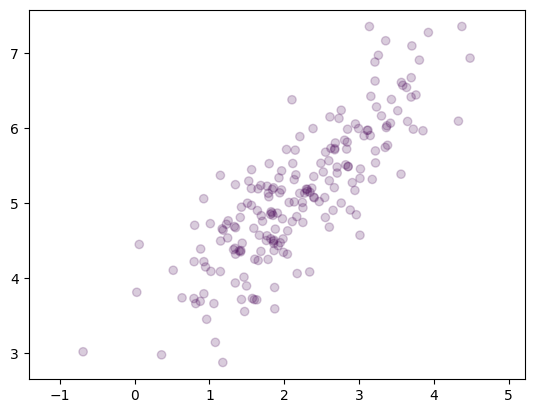

In [3]:
# mean and covariance
mean = np.asarray([2.0, 5.0])
cov = np.asarray([[1.0, 0.85], [0.85, 1.0]])

# training set of 2D points - used to create a model
training_size = 200
X_train = np.random.multivariate_normal(mean, cov, training_size)
y_train = [0]*training_size

print('Training data:')
plot(X_train, y_train)

# PCA transformation

[2.17741415 5.09990178] 

[[-0.70838385 -0.7058274 ]
 [-0.7058274   0.70838385]] 

[1.48380785 0.14398489] 

[0.91154593 0.08845407] 



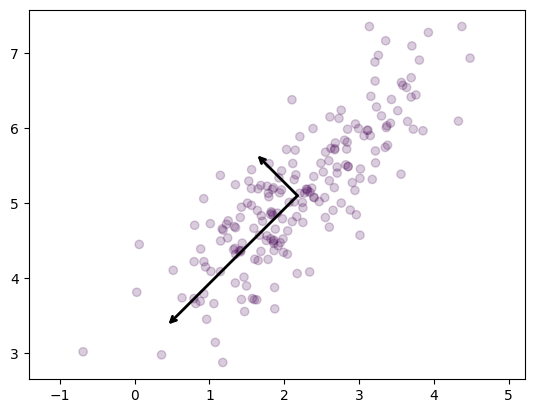

In [4]:
pca = PCA(n_components=2)
pca.fit(X_train)

# mean point
print(pca.mean_, '\n')

# principal components - "main data directions"
print(pca.components_, '\n')

# variance per component - "amount of encoded data per axis"
print(pca.explained_variance_, '\n')

# percentage of variation per component
print(pca.explained_variance_ratio_, '\n')

plot(X_train, y_train, pca)

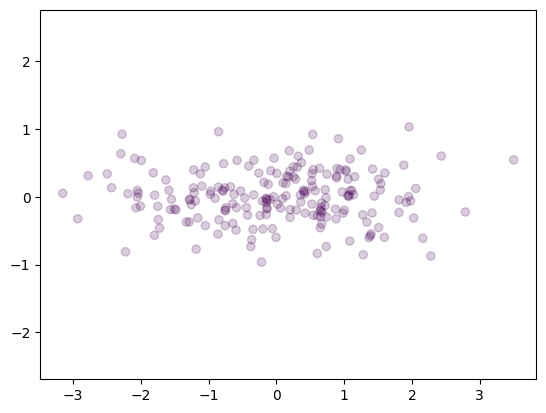

In [5]:
X_train_projected = pca.transform(X_train)

plot(X_train_projected, y_train)

# PCA for dimensionality reduction

In [6]:
pca = PCA(n_components=1)
pca.fit(X_train)
X_train_projected = pca.transform(X_train)

print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_projected.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


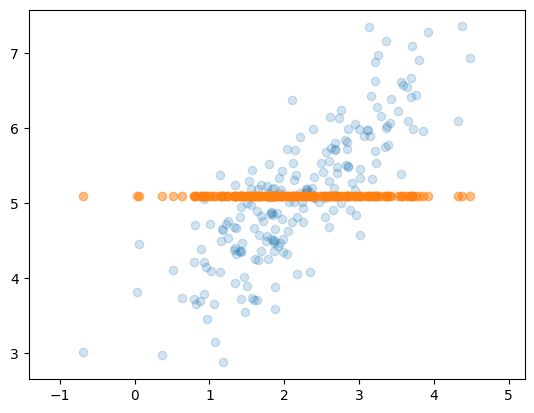

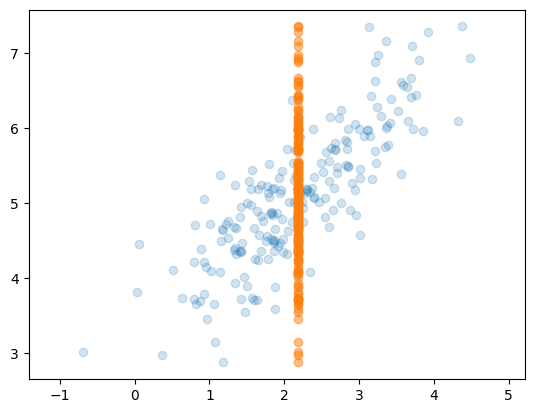

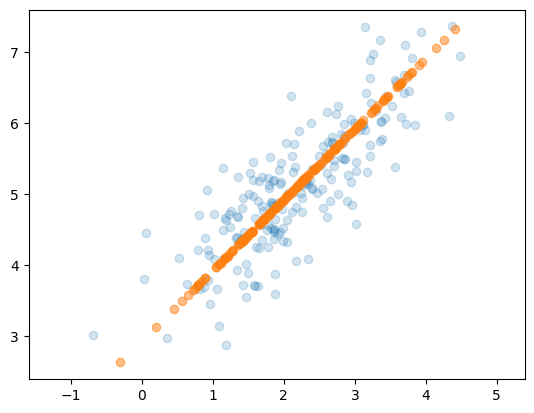

In [7]:
# keep the 1st axis
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2)
plt.scatter(X_train[:, 0], [pca.mean_[1]]*len(X_train), alpha=0.5)
plt.axis('equal')
plt.show()

# keep the 2nd axis
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2)
plt.scatter([pca.mean_[0]]*len(X_train), X_train[:, 1], alpha=0.5)
plt.axis('equal')
plt.show()

# keep the 1st principal component
X_train_reconstruction = pca.inverse_transform(X_train_projected)
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2)
plt.scatter(X_train_reconstruction[:, 0], X_train_reconstruction[:, 1], alpha=0.5)
plt.axis('equal')
plt.show()

# PCA for visualization

In [8]:
# load MNIST dataset using Keras
(X_mnist, y_mnist), _ = mnist.load_data()

print("X_train shape", X_mnist.shape)
print("y_train shape", y_mnist.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)


In [9]:
def show_images(imgs, num_rows, num_cols):
    assert len(imgs) == num_rows*num_cols

    for i in range(num_rows):
        row = None
        for j in range(num_cols):
            if row is None:
                row = imgs[i*num_cols+j]
            else:
                row = np.concatenate((row, imgs[i*num_cols+j]), axis=1)
        plt.imshow(row, cmap='gray')
        plt.axis('off')
        plt.show()

(200, 784) uint8
(200,) int64


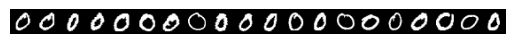

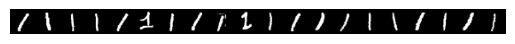

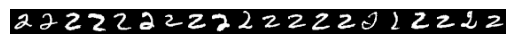

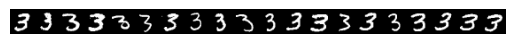

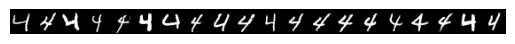

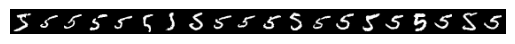

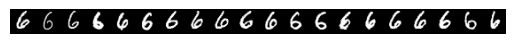

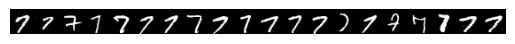

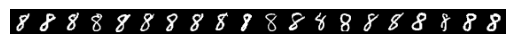

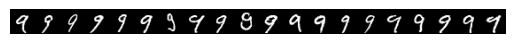

In [10]:
N_SAMPLES = 20
N_CLASSES = 10

# get the first N_SAMPLES training images per class
indices = []
y_train = []
for i in range(N_CLASSES):
    indices += list(np.where(y_mnist == i)[0][:N_SAMPLES])
    y_train += [i]*N_SAMPLES
X_train = X_mnist[indices].reshape(N_SAMPLES*N_CLASSES, -1)
y_train = np.asarray(y_train)

print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)

show_images(X_train.reshape(-1, 28, 28), N_CLASSES, N_SAMPLES)

In [11]:
pca = PCA(n_components=2)  # project from 784 to 2 dimensions
X_train_projected = pca.fit_transform(X_train)
print(X_train.shape)
print(X_train_projected.shape)

print(pca.explained_variance_ratio_)

(200, 784)
(200, 2)
[0.1106315  0.07312174]


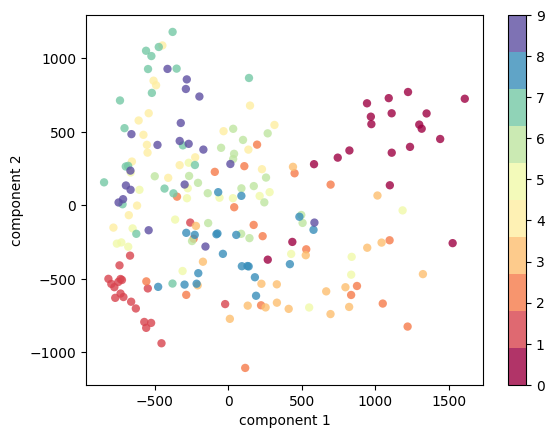

In [12]:
plt.scatter(X_train_projected[:, 0], X_train_projected[:, 1], c=y_train, edgecolor='none', alpha=0.8, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

# PCA for noise filtering

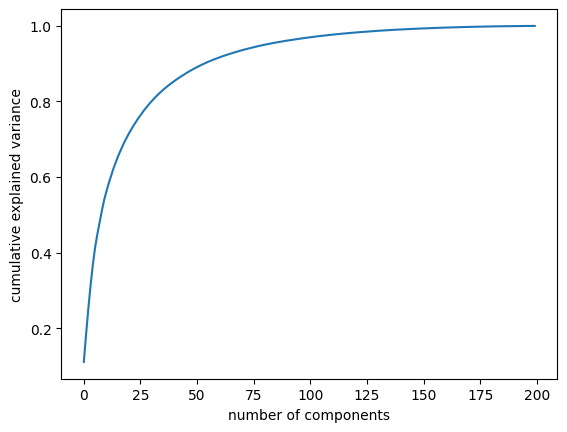

In [14]:
# compute all components and plot the rate of variance kept in the first K components
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

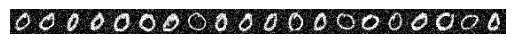

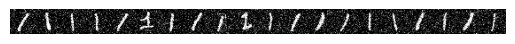

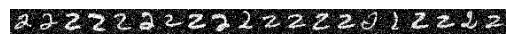

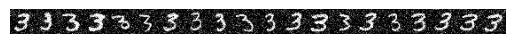

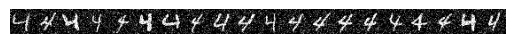

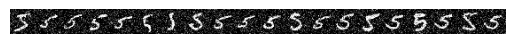

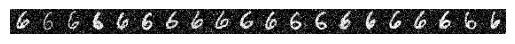

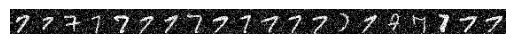

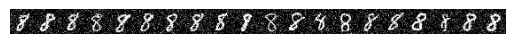

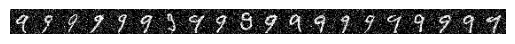

In [15]:
# create noisy training data
X_train_noisy = np.clip(np.random.normal(X_train, 64), 0, 255).astype(np.uint8)
show_images(X_train_noisy.reshape(-1, 28, 28), N_CLASSES, N_SAMPLES)

21


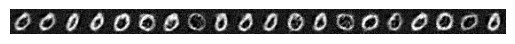

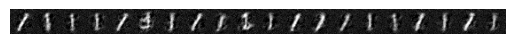

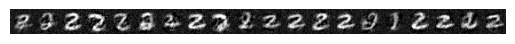

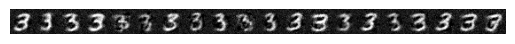

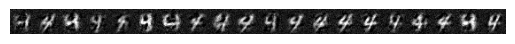

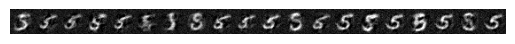

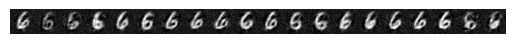

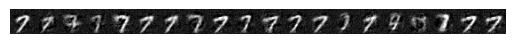

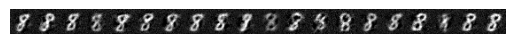

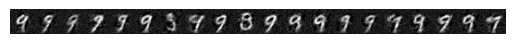

In [17]:
pca = PCA(0.50).fit(X_train_noisy)
print(pca.n_components_)

X_train_projected = pca.transform(X_train_noisy)
X_train_filtered = np.clip(pca.inverse_transform(X_train_projected), 0, 255).astype(np.uint8)
show_images(X_train_filtered.reshape(-1, 28, 28), N_CLASSES, N_SAMPLES)

# PCA for one-class classification

In [18]:
training_class = 0 # single-class for training

N_SAMPLES = 50 # get three subsets of N_SAMPLES (training, validation, test)
N_CLASSES = 10

# get the first N_SAMPLES training images per class
train_indices = []
val_indices = []
test_indices = []
y_train = []
for i in range(N_CLASSES):
    if i == training_class:
        train_indices += list(np.where(y_mnist == i)[0][:N_SAMPLES])
    val_indices += list(np.where(y_mnist == i)[0][N_SAMPLES:2*N_SAMPLES])
    test_indices += list(np.where(y_mnist == i)[0][2*N_SAMPLES:3*N_SAMPLES])
    y_train += [i]*N_SAMPLES
X_train = X_mnist[train_indices].reshape(N_SAMPLES, -1)
X_val = X_mnist[val_indices].reshape(N_SAMPLES*N_CLASSES, -1)
X_test = X_mnist[test_indices].reshape(N_SAMPLES*N_CLASSES, -1)
y_train = np.asarray(y_train)
y_val = y_train.copy()
y_test = y_train.copy()

print('Training:')
show_images(X_train.reshape(-1, 28, 28), 1, N_SAMPLES)

print('Validation:')
show_images(X_val.reshape(-1, 28, 28), N_CLASSES, N_SAMPLES)

print('Test:')
show_images(X_test.reshape(-1, 28, 28), N_CLASSES, N_SAMPLES)

Training:


Validation:


Test:


In [19]:
# find best number of eigenvectors and distance threshold using validation set
for i in range(1,50):
    pca = PCA(n_components=i).fit(X_train)
    X_val_projected = pca.transform(X_val)
    
    # Mahalanobis distance
    dist = np.sqrt(np.sum(X_val_projected**2 / pca.explained_variance_, axis=1))

    positive = dist[np.where(y_val == training_class)]
    negative = dist[np.where(y_val != training_class)]
    
    # find threshold with best fscore
    best_fscore = 0.0
    best_thr = 0.0
    for thr in np.arange(0.1, 5.0, 0.1):
        true_positives = len(positive[np.where(positive < thr)])
        false_positives = len(negative[np.where(negative < thr)])
        
        if true_positives+false_positives == 0:
            precision = 0
        else:
            precision = true_positives/(true_positives+false_positives)
        recall = true_positives/len(positive)
        
        if precision+recall == 0:
            fscore = 0
        else:
            fscore = (2.0*precision*recall)/(precision+recall)

        if fscore > best_fscore:
            best_fscore = fscore
            best_thr = thr

    print('{} {:.3f} {:.3f}'.format(i, best_thr, best_fscore))

1 1.600 0.182
2 0.900 0.231
3 1.900 0.275
4 1.700 0.279
5 2.300 0.250
6 2.300 0.241
7 2.600 0.221
8 2.400 0.213
9 2.500 0.213
10 3.900 0.183
11 3.900 0.186
12 2.700 0.212
13 2.800 0.230
14 2.900 0.271
15 3.200 0.217
16 3.300 0.246
17 3.700 0.234
18 3.400 0.315
19 3.700 0.319
20 3.900 0.333
21 3.900 0.314
22 3.600 0.293
23 3.800 0.302
24 3.900 0.286
25 4.000 0.289
26 4.000 0.274
27 4.000 0.269
28 4.600 0.368
29 4.600 0.333
30 4.600 0.372
31 4.900 0.390
32 4.800 0.400
33 4.800 0.381
34 4.800 0.395
35 4.800 0.406
36 4.900 0.400
37 4.900 0.364
38 4.900 0.344
39 4.900 0.328
40 4.900 0.328
41 4.900 0.271
42 4.900 0.276
43 4.900 0.214
44 4.900 0.214
45 4.900 0.214
46 4.900 0.148
47 4.900 0.148
48 4.600 0.077
49 4.600 0.077


In [20]:
# inference results on test set
n_components=35
thr = 4.8

pca = PCA(n_components=n_components).fit(X_train)
X_test_projected = pca.transform(X_test)

# Mahalanobis distance
dist = np.sqrt(np.sum(X_test_projected**2 / pca.explained_variance_, axis=1))

positive = dist[np.where(y_val == training_class)]
negative = dist[np.where(y_val != training_class)]

true_positives = len(positive[np.where(positive < thr)])
false_positives = len(negative[np.where(negative < thr)])

if true_positives+false_positives == 0:
    precision = 0
else:
    precision = true_positives/(true_positives+false_positives)
recall = true_positives/len(positive)
        
if precision+recall == 0:
    fscore = 0
else:
    fscore = (2.0*precision*recall)/(precision+recall)

print('Test Precision: {:.2f}'.format(precision))
print('Test Recall: {:.2f}'.format(recall))
print('Test F-score: {:.2f}'.format(fscore))

Test Precision: 0.70
Test Recall: 0.28
Test F-score: 0.40
